# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score


## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [3]:
PATH = "~/data/"
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [4]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [5]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [6]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [9]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

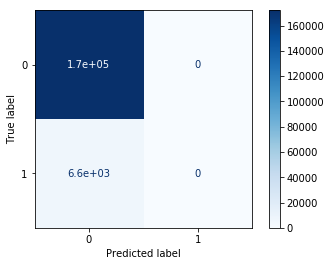

In [10]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [11]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

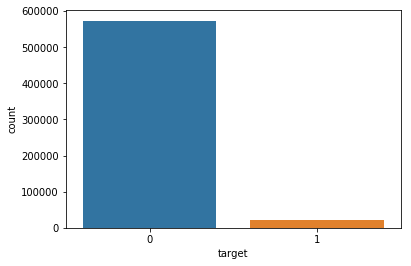

In [12]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [13]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

ROC curve builds with using the following rules:
1. By Y-axis represents the proportion of truly positive events
2. By X-axis represents the proportion of false positive events
3. Then we need to estimate the area under curve (AUC)

It can be represented by the formula::
$$AUC = \frac{1}{2}\sum\limits_{i}(y_{j+1} + y_{j})(x_{i+1} - x_{i})$$

$$y_{i} - \text{proportion of truly positive events for i-th}$$
$$x_{i} - \text{proportion of false positive events for i-th}$$

To calculate the Gini index, we investigate the dependence of the proportion of incorrectly classified positive events in the total number of positive events on the proportion of correctly classified negative events in the total number of negative events (Lorentz curve).

Lorentz curve bulds with using the following rules:
1. By Y-axis represents the proportion of negatively classified positive events (1 - TPR)
2. By X-axis represents the proportion of positively classified false events (1 - FPR)

Gini coeffcient it's the relation of the area of the figure formed by the Lorentz curve and the diagonal of the unit square to half the area of the unit square.

It can be represented by the formula:

$$Gini = 1 - \sum\limits_{i}(y_{j+1} + y_{j})(x_{i+1} - x_{i})$$

$$y_{i} - \text{proportion of misclassified positive events for i-th}$$
$$x_{i} - \text{proportion of correctly classified negative events for i-th}$$

From these formulas is obvious that the Gini coefficient and AUC related by the following expression:

$$Gini = 2 \times AUC - 1$$

We see on the chart that the Lorentz curve is centrally symmetric to the ROC curve

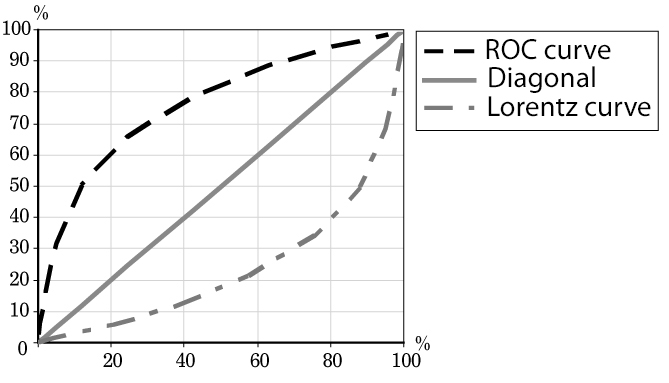

To simplify the interpretation, we will mark the areas with letters.

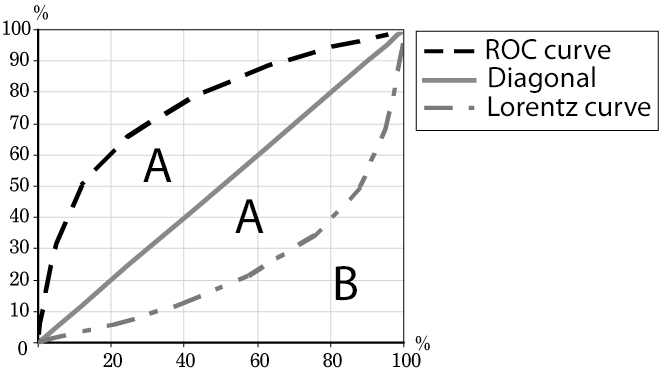

So as we know Gini coefficient it's the relation of the area of the figure formed by the Lorentz curve and the diagonal of the unit square to half the area of the unit square. It means Gini coefficient will be equal to:
$$Gini = \frac{A}{A+B}$$
where A+B is half the area of a unit square and equal to 0.5, so we can replace A + B with using this value:
$$Gini = \frac{A}{0.5}=2A$$

Also by using the similar approach we can describe the AUC value.
$$AUC = A + (A + B) = A + 0.5$$

With using this method we again see that the:
$$Gini = 2 \times AUC - 1$$

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

For imbalanced models, we can use the following metrics:
1. Precision
2. Recall
3. F-1 (F-score)
4. Cohen's kappa coefficient

Let's calculate the Normalized Gini Coefficient:

In [14]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [15]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [16]:
from sklearn.ensemble import RandomForestClassifier

reg = RandomForestClassifier(max_depth=2, random_state=42)

reg.fit(X_train, y_train)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(reg, X_train, 
                                                           y_train, scoring='accuracy', cv=5).mean()))

Result with using Random Forest classifier: 0.963737


In [17]:
def roc_auc_chart(X_valid, y_validf, reg):
    import sklearn.metrics as metrics
    probs = reg.predict_proba(X_valid)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

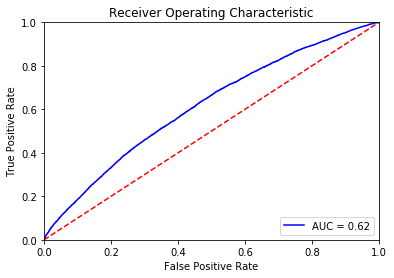

In [18]:
roc_auc_chart(X_valid, y_valid, reg)

In [19]:
pip install -U delayed


The following command must be run outside of the IPython shell:

    $ pip install -U delayed

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [20]:
pip install -U imbalanced-learn


The following command must be run outside of the IPython shell:

    $ pip install -U imbalanced-learn

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


Undersampling example:

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.fixes import delayed

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

print("Before undersampling: ", len(y_train))

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print("After undersampling: ", len(y_train_under))

reg = RandomForestClassifier(max_depth=2, random_state=42)
reg.fit(X_train_under, y_train_under)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(reg, X_train_under, 
                                                           y_train_under, scoring='accuracy', cv=5).mean()))

roc_auc_chart(X_valid, y_valid, reg)

ModuleNotFoundError: No module named 'imblearn'

Oversampling example:

In [ ]:
from imblearn.over_sampling import SMOTE

print("Before oversampling: ", len(y_train))

smote = SMOTE()

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

print("After oversampling: ", len(y_train_SMOTE))

reg = RandomForestClassifier(max_depth=2, random_state=42)
reg.fit(X_train_SMOTE, y_train_SMOTE)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(reg, X_train_SMOTE, 
                                                           y_train_SMOTE, scoring='accuracy', cv=5).mean()))

roc_auc_chart(X_valid, y_valid, reg)

With using both approaches

In [ ]:
from imblearn.pipeline import Pipeline

reg = RandomForestClassifier(max_depth=2, random_state=42)
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('o', over), ('u', under), ('model', reg)])

pipeline.fit(X_train, y_train)

print('Result with using Random Forest classifier: {:f}'.format(cross_val_score(pipeline, X_train, 
                                                           y_train, scoring='accuracy', cv=5).mean()))

roc_auc_chart(X_valid, y_valid, pipeline)


In [ ]:

test_X = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

predictions = pipeline.predict(test_X)

output = pd.DataFrame({ 'id' : test_X.index, 'target': predictions })
output.to_csv('submission.csv', index=False)

#Kaggle result  0.06327 dmvoro dmvoro